In [19]:
from pl_bolts.models.self_supervised.simclr import SimCLREvalDataTransform
from torch.utils.data import Dataset, DataLoader, random_split
from pl_bolts.models.self_supervised import SimCLR, BYOL
from livelossplot import PlotLosses
import torchvision.transforms as T
import pytorch_lightning as pl
from time import time
from PIL import Image
import torchmetrics
import pandas as pd
import numpy as np
import torch
import os

In [20]:
def get_best_checkpoint(selected_model):
    logs_dir = os.path.join(
        os.path.expanduser('~'),
        'icdar', selected_model,
        'lightning_logs'
    )

    best_version = max(
        map(
            lambda x: int(x.replace('version_', '')) if 'version' in x else 0,
            os.listdir(logs_dir)
        )
    )

    version_dir = os.path.join(logs_dir, f'version_{best_version}', 'checkpoints')

    return os.path.join(version_dir, os.listdir(version_dir)[0])

In [21]:
class ICDARDataset(Dataset):

    def __init__(self, csv_filepath, root_dir, transforms=None, convert_rgb=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.data = pd.read_csv(csv_filepath, sep=';')
        self.convert_rgb = convert_rgb

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.data.loc[idx, 'FILENAME'])
        
        try:
            image = Image.open(img_path)
        except Exception as ex:
            return None

        if self.convert_rgb:
            image = image.convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, self.data.loc[idx, 'SCRIPT_TYPE']


In [22]:
def load_best_checkpoint(model_name):
    
    checkpoint = get_best_checkpoint(model_name)
    
    if model_name == 'SimCLR':
        model = SimCLR.load_from_checkpoint(checkpoint, strict=False)
        embeddings_model = model.encoder.cuda()
        embeddings_model.eval()
    elif model_name == 'BYOL':
        model = BYOL.load_from_checkpoint(checkpoint, strict=False)
        embeddings_model = model.encoder.cuda()
        embeddings_model.eval()
    else:
        model = SimCLR.load_from_checkpoint(checkpoint, strict=False)
        embeddings_model = model.encoder.cuda()
        embeddings_model.eval()
    
    return embeddings_model

In [23]:
def data_factory(dataset_name, root_dir, label_filepath, transforms, mode, batch_size, collate_fn=None):

    if dataset_name.lower() == 'icdar':
        dataset = ICDARDataset(label_filepath, root_dir, transforms=transforms(), convert_rgb=True)
    else:
        raise NotImplementedError(f'Dataset {dataset_name} is not implemented')

    total_count = len(dataset)
    train_count = int(0.7 * total_count)
    val_count = int(0.2 * total_count)
    test_count = total_count - train_count - val_count

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        (train_count, val_count, test_count)
    )

    if mode in 'train':
        return {
            'train': DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                pin_memory=True,
                num_workers=os.cpu_count(),
                collate_fn=collate_fn() if collate_fn else None
            ),
            'val': DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                pin_memory=True,
                num_workers=os.cpu_count(),
                collate_fn=collate_fn() if collate_fn else None
            )
        }
    elif mode == 'test':
        return {
            'test': DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                pin_memory=True,
                num_workers=os.cpu_count(),
                collate_fn=collate_fn() if collate_fn else None
            )
        }
    else:
        raise KeyError(f'Unknown mode: {mode}')


In [24]:
class Classifier(torch.nn.Module):
    
    def __init__(self, features, num_classes, learning_rate=2e-4):
        super().__init__()
        
        self.learning_rate = learning_rate

        self.fc1 = torch.nn.Linear(features, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)
    
    # will be used during inference
    def forward(self, x):

       x = torch.nn.functional.relu(self.fc1(x))
       x = torch.nn.functional.relu(self.fc2(x))
       x = torch.nn.functional.softmax(self.fc3(x), dim=1)
       
       return x


In [40]:
def train_downstream_model(model_name, max_epochs=10):
    root_dir = os.path.join(
        os.path.expanduser('~'),
        'icdar', 'data', 'ICDAR2017_CLaMM_Training'
    )
    dataloaders = data_factory(
        dataset_name='icdar',
        root_dir=root_dir, 
        label_filepath=os.path.join(root_dir, '@ICDAR2017_CLaMM_Training.csv'),
        transforms=SimCLREvalDataTransform,
        mode='train',
        batch_size=32
    )
    embeddings_model = load_best_checkpoint(model_name)
    downstream_model = Classifier(2048, 13)
    downstream_model = downstream_model.to('cuda')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(downstream_model.parameters(), lr=0.001)
    liveloss = PlotLosses()
    
    for epoch in range(max_epochs):
        logs = {}
        
        for mode in ['train', 'val']:
            
            if mode == 'train':
                downstream_model.train()
            else:
                downstream_model.eval()

            running_loss = 0
            running_corrects = 0
        
            for i, batch in enumerate(dataloaders.get(mode)):
                (x1, x2, _), label = batch
                label = label.to('cuda')

                embedding = embeddings_model(x1.to('cuda'))[-1]
                
                out = downstream_model(embedding)

                loss = criterion(out, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(out, 1)
                running_loss += loss.detach() * x1.size(0)
                running_corrects += torch.sum(preds == label.data)

            epoch_loss = running_loss / len(dataloaders.get(mode).dataset)
            epoch_acc = running_corrects.float() / len(dataloaders.get(mode).dataset)
            prefix = ''
            if mode == 'val':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
            
        liveloss.update(logs)
        liveloss.send()
    
    return downstream_model



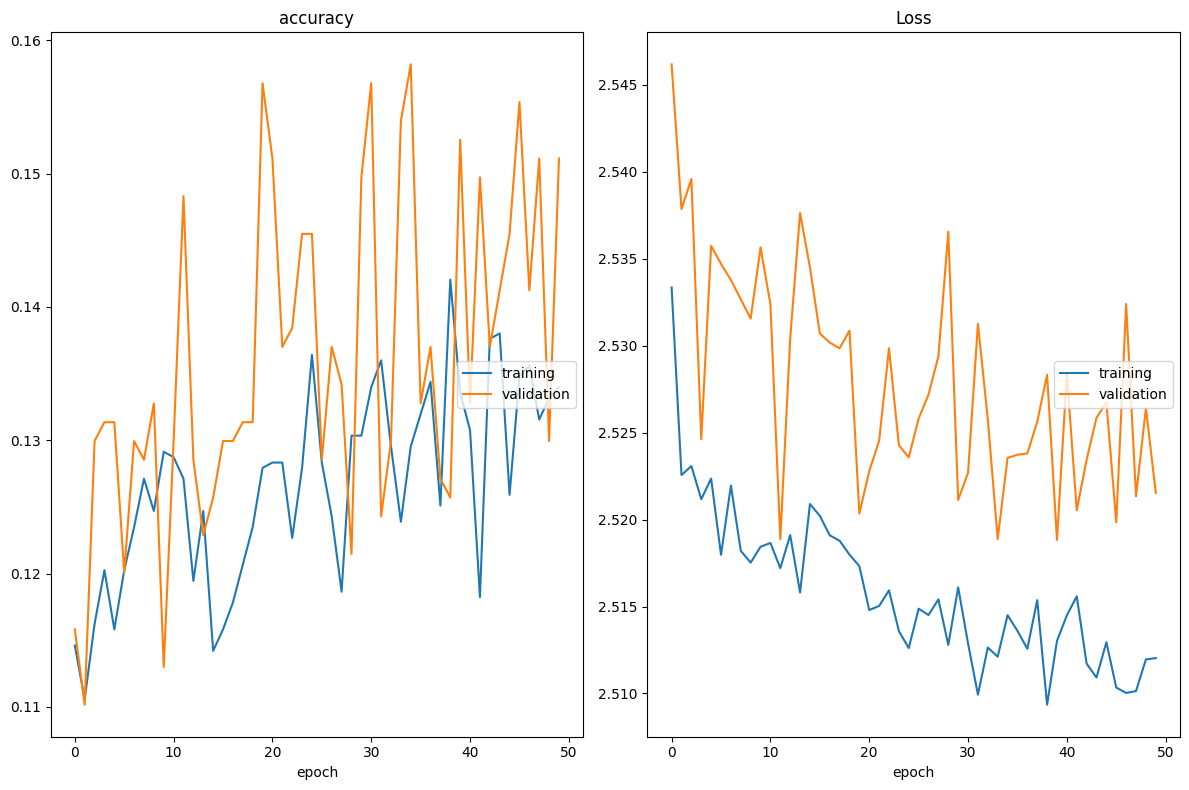

accuracy
	training         	 (min:    0.111, max:    0.142, cur:    0.134)
	validation       	 (min:    0.110, max:    0.158, cur:    0.151)
Loss
	training         	 (min:    2.509, max:    2.533, cur:    2.512)
	validation       	 (min:    2.519, max:    2.546, cur:    2.522)


In [41]:
downstream_model = train_downstream_model('SimCLR', 50)

In [ ]:
torch.save(downstream_model.state_dict(), 'model.pt')

In [44]:
def test_downstream_model(model_name, downstream_model):
    root_dir = os.path.join(
        os.path.expanduser('~'),
        'icdar', 'data', 'ICDAR2017_CLaMM_Training'
    )
    dataloaders = data_factory(
        dataset_name='icdar',
        root_dir=root_dir, 
        label_filepath=os.path.join(root_dir, '@ICDAR2017_CLaMM_Training.csv'),
        transforms=SimCLREvalDataTransform,
        mode='test',
        batch_size=32
    )
    embeddings_model = load_best_checkpoint(model_name)

    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloaders.get('test'):
            (x1, x2, _), label = batch
            features = embeddings_model(x1.to('cuda'))
            outputs = downstream_model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")


In [45]:
test_downstream_model('SimCLR', downstream_model)

/home/uj43ugat/miniconda3/envs/icdar/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:225: UnderReviewWarning: The feature SimCLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/home/uj43ugat/miniconda3/envs/icdar/lib/python3.10/site-packages/pl_bolts/models/self_supervised/simclr/simclr_module.py:138: UnderReviewWarning: The feature resnet50 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return backbone(first_conv=self.first_conv, maxpool1=self.maxpool1, return_all_feature_maps=Fa

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list